In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder


In [30]:
path = '/Users/SebastianBerko/Documents/Bank Term Deposit Prediction/data.db'
conn = sqlite3.connect(path)
cursor = conn.cursor()

In [31]:
# Find the table names and exclude system file
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
tables = [row[0] for row in cursor.fetchall() if row[0] != 'sqlite_sequence']  # Exclude system tables if needed

# Dictionary to store DataFrames
dataframes = {}

# Loop through each table and fetch data
for table in tables:
    query = f"SELECT * FROM {table}"
    cursor.execute(query)
    rows = cursor.fetchall()
    
    # Get column names for the DataFrame
    column_names = [desc[0] for desc in cursor.description]
    
    # Create DataFrame and store it in the dictionary
    dataframes[table] = pd.DataFrame(rows, columns=column_names)

# Access individual DataFrames
accounts = dataframes['Accounts']
campaigns = dataframes['Campaigns']
clients = dataframes['Clients']
outcomes = dataframes['Outcomes']

conn.close()



In [ ]:
# Rename columns for clarity
renamed_dataframes = {
    "accounts": accounts.rename(columns={"id": "account_id"}),
    "campaigns": campaigns.rename(columns={"id": "campaign_id"}),
    "clients": clients.rename(columns={"id": "client_id"}),
    "outcomes": outcomes.rename(columns={"id": "outcome_id"}),
}

# Perform successive merges
merged_data = (
    renamed_dataframes["clients"]
    .merge(renamed_dataframes["accounts"], on="client_id", suffixes=("", "_drop"))
    .merge(renamed_dataframes["campaigns"], on="account_id", suffixes=("", "_drop"))
    .merge(renamed_dataframes["outcomes"], on="campaign_id", suffixes=("", "_drop"))
)

# Drop unwanted duplicate columns created by merges
columns_to_drop = [col for col in merged_data.columns if col.endswith("_drop")]
bank_data = merged_data.drop(columns=columns_to_drop)

# Rename any necessary columns
bank_data = bank_data.rename(columns={"campaign_id": "campaign_id_x"})

#Change the month and date column to datetime

#bank_data['date'] = pd.to_datetime(bank_data[['month', 'day']].astype(str).agg('-'.join, axis=1),format='%b-%d')

# Group days into ranges
def day_range(day):
    if day <= 10:
        return 'Early Month'
    elif day <= 20:
        return 'Mid Month'
    else:
        return 'Late Month'

bank_data['day_range'] = bank_data['day'].apply(day_range)

# Updating the column name in the code to reflect the correct dataframe name 'bank_data'

# Binning age
age_bins = [0, 20, 30, 40, 60, float('inf')]
age_labels = ['Teen', 'Young Adult', 'Adult', 'Middle-aged', 'Senior']
bank_data['age_category'] = pd.cut(bank_data['age'], bins=age_bins, labels=age_labels, right=False)

#binning balance
balance_bins = [-float('inf'), 0, 500, 1000, 2000, 3000, 4000, 5000, 10000, float('inf')]
balance_labels = [
    'Negative', 'Very Low', 'Low', 'Medium-Low', 
    'Medium', 'Medium-High', 'High', 'Very High', 'Ultra High']
bank_data['balance_category'] = pd.cut(bank_data['balance'], bins=balance_bins, labels=balance_labels, right=False)

# Binning duration
duration_bins = [0, 200, 500, 1000, float('inf')]
duration_labels = ['Short', 'Moderate', 'Long', 'Very Long']
bank_data['duration_category'] = pd.cut(bank_data['duration'], bins=duration_bins, labels=duration_labels, right=False)

# Binning campaign
campaign_bins = [0, 3, 10, float('inf')]
campaign_labels = ['Few', 'Moderate', 'Many']
bank_data['campaign_category'] = pd.cut(bank_data['campaign'], bins=campaign_bins, labels=campaign_labels, right=False)

# Binning pdays
pdays_bins = [-2, -1, 100, float('inf')]
pdays_labels = ['No Previous Contact', 'Recent', 'Distant']
bank_data['pdays_category'] = pd.cut(bank_data['pdays'], bins=pdays_bins, labels=pdays_labels, right=False)

# Binning previous
previous_bins = [-1, 0, 3, float('inf')]
previous_labels = ['None', 'Few', 'Many']
bank_data['previous_category'] = pd.cut(bank_data['previous'], bins=previous_bins, labels=previous_labels, right=False)

unique

# Display or further process
bank_data.head()


,client_id,age,job,marital,education,account_id,in_default,balance,housing,loan,...,outcome_id,poutcome,y,day_range,age_category,balance_category,duration_category,campaign_category,pdays_category,previous_category
0,1000583,43,management,married,tertiary,19298,no,-127.0,no,no,...,19298,unknown,unknown,Early Month,Middle-aged,Negative,Moderate,Few,Recent,Few
1,1000708,45,management,divorced,secondary,18266,no,51.0,yes,no,...,18266,unknown,unknown,Late Month,Middle-aged,Low,Short,Moderate,Recent,Few
2,1000951,35,management,single,tertiary,24000,no,385.0,yes,no,...,24000,unknown,unknown,Late Month,Adult,Low,Short,Few,Recent,Few
3,1001250,29,blue-collar,single,secondary,5448,no,1012.0,yes,no,...,5448,unknown,unknown,Late Month,Young Adult,Medium,Long,Few,Recent,Few
4,1001280,50,blue-collar,married,unknown,19620,no,123.0,yes,no,...,19620,unknown,unknown,Early Month,Middle-aged,Low,Moderate,Few,Recent,Few


In [ ]:
#Splitting data into population and previous campaign sample data

population = bank_data[bank_data['y'] == 'unknown']

campaign_sample = bank_data[bank_data['y'] != 'unknown']


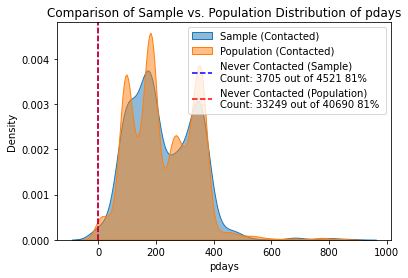

In [57]:
# Separate pdays for contacted group in the sample and population
contacted_pdays_sample = campaign_sample[campaign_sample['pdays'] > -1]['pdays']
contacted_pdays_population = population[population['pdays'] > -1]['pdays']

# Density plot for contacted group in sample and population
sns.kdeplot(contacted_pdays_sample, label="Sample (Contacted)", fill=True, alpha=0.5)
sns.kdeplot(contacted_pdays_population, label="Population (Contacted)", fill=True, alpha=0.5)

# Add spike or bar for "Never Contacted" in both sample and population
never_contacted_sample_count = (campaign_sample['pdays'] == -1).sum()
never_contacted_population_count = (population['pdays'] == -1).sum()
sample_size = len(campaign_sample)
population_size = len(population)

# Add spikes for "Never Contacted" proportionally scaled
plt.axvline(-1, color='blue', linestyle='--', label=f"Never Contacted (Sample)\nCount: {never_contacted_sample_count} out of {sample_size} {int(never_contacted_sample_count/sample_size*100)}% ")
plt.axvline(-1, color='red', linestyle='--', label=f"Never Contacted (Population)\nCount: {never_contacted_population_count} out of {population_size} {int(never_contacted_population_count/population_size*100)}% ")

# Labels and legend
plt.xlabel('pdays')
plt.ylabel('Density')
plt.title('Comparison of Sample vs. Population Distribution of pdays')
plt.legend()
plt.show()


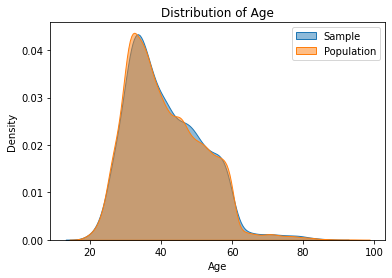

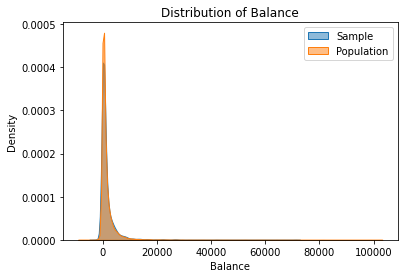

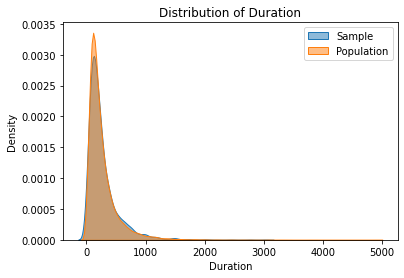

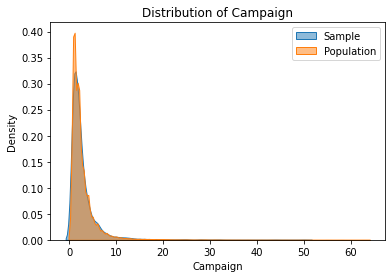

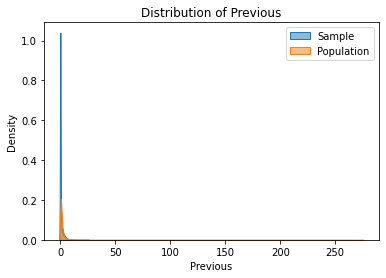

In [58]:
# Compare distributions of numerical variables
for column in ['age', 'balance', 'duration', 'campaign', 'previous']:
    sns.kdeplot(campaign_sample[column], label='Sample', fill=True, alpha=0.5)
    sns.kdeplot(population[column], label='Population', fill=True, alpha=0.5)
    plt.xlabel(column.capitalize())
    plt.ylabel('Density')
    plt.title(f'Distribution of {column.capitalize()}')
    plt.legend()
    plt.show()

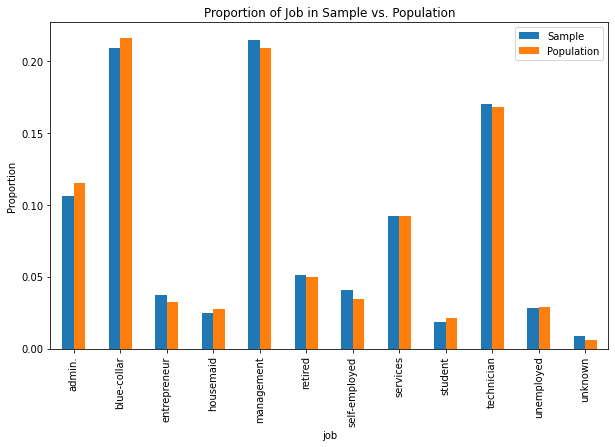

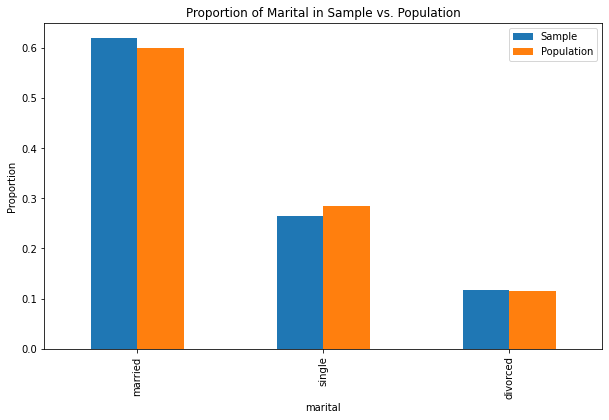

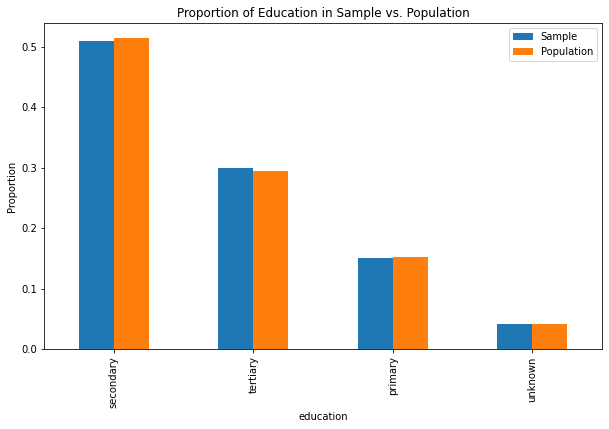

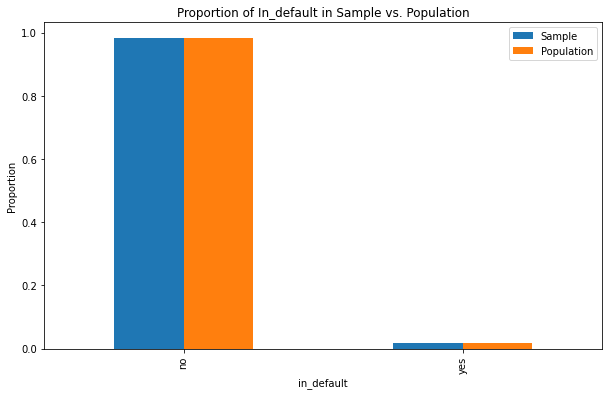

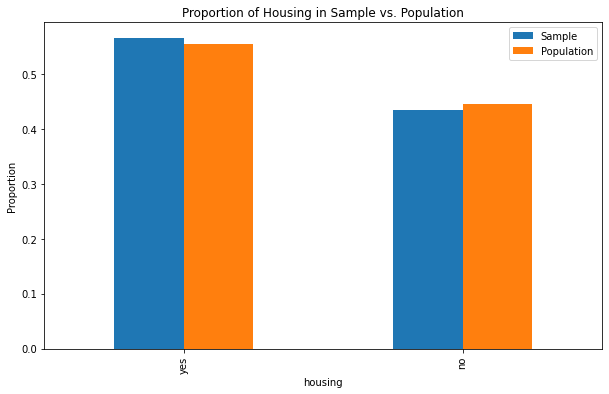

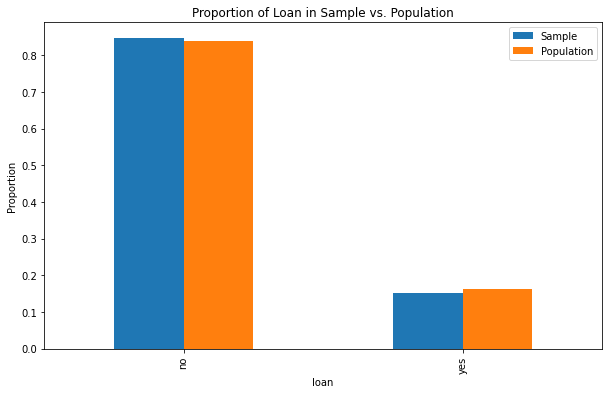

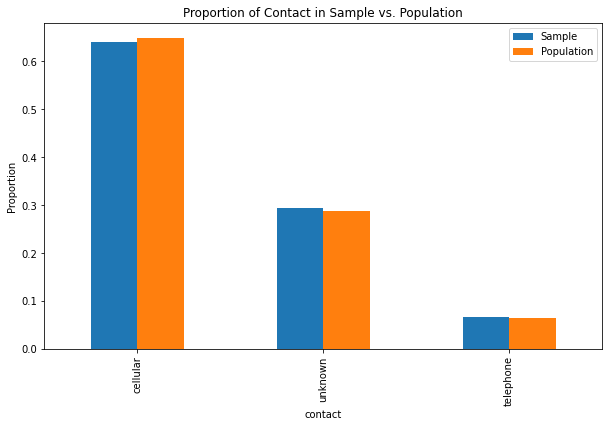

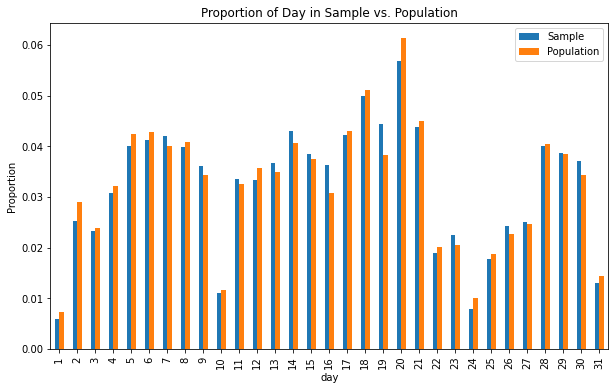

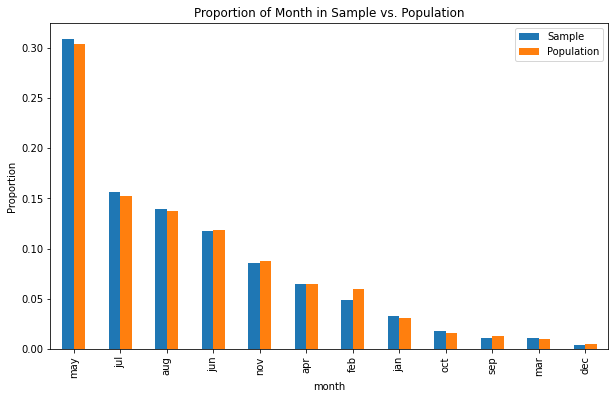

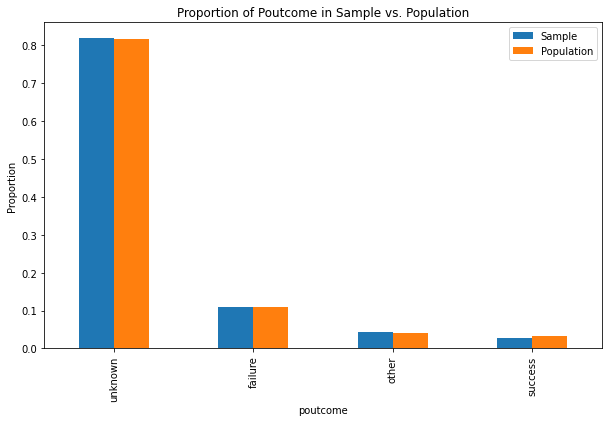

In [60]:
# Compare proportions of a categorical variable
for column in ['job', 'marital', 'education', 'in_default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome']:
    sample_counts = campaign_sample[column].value_counts(normalize=True)
    population_counts = population[column].value_counts(normalize=True)

    comparison_df = pd.DataFrame({
        'Sample': sample_counts,
        'Population': population_counts
    }).fillna(0)

    comparison_df.plot(kind='bar', figsize=(10, 6))
    plt.ylabel('Proportion')
    plt.title(f'Proportion of {column.capitalize()} in Sample vs. Population')
    plt.show()
